### Preliminaries


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
random_state = 0
import seaborn as sns
sys.path.append(os.path.dirname(os.getcwd()))
from data_prep import fetch_data, time_series_features, add_lag_features, simple_moving_average
# from mean_reversion import mean_reversion_strategy
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


### Fetch Data

In [5]:
df = fetch_data('XOM', '1990-01-01', '2023-12-31')
# df['SMA_10'] = simple_moving_average(df, 10)
df = df.reset_index()
df['Date'] = df['Date'].dt.date
df.drop(columns=['Open', 'High', 'Volume','Low', 'Dividends', 'Stock Splits'], inplace=True)


### Data Preparation

In [6]:
df = add_lag_features(df)
# df = time_series_features(df)
cols = list(df.columns)
cols.remove('Close')
cols.append('Close')
df = df[cols]
df = df.dropna()

In [7]:
df

,Date,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_5,Close_lag_10,Close
10,1990-01-16,3.771591,3.722862,3.820319,3.781335,3.898284,3.752098
11,1990-01-17,3.752098,3.771591,3.722862,3.800824,3.859302,3.693624
12,1990-01-18,3.693624,3.752098,3.771591,3.820319,3.820319,3.742355
13,1990-01-19,3.742355,3.693624,3.752098,3.722862,3.800824,3.791083
14,1990-01-22,3.791083,3.742355,3.693624,3.771591,3.859302,3.664387
...,...,...,...,...,...,...,...
8560,2023-12-22,99.182671,98.734177,100.411110,98.373451,97.057259,99.358162
8561,2023-12-26,99.358162,99.182671,98.734177,99.104675,97.125511,99.582405
8562,2023-12-27,99.582405,99.358162,99.182671,100.411110,95.594818,99.114426
8563,2023-12-28,99.114426,99.582405,99.358162,98.734177,96.443024,97.681236


In [8]:
def windowed_df_to_date(df):
    dates = df['Date'].values
    features = df.drop(['Date', 'Close'], axis=1).values
    X = features.reshape((len(dates), features.shape[1], 1))
    y = df['Close'].values
    return X.astype(np.float32), y.astype(np.float32), dates

X, y, dates = windowed_df_to_date(df)


### Train/Val/Test Split


In [9]:
q_80 = int(len(df) * 0.8)
q_90 = int(len(df) * 0.9)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

dates_train = dates[:q_80]
dates_val = dates[q_80:q_90]
dates_test = dates[q_90:]

X_train = X_scaled[:q_80]
X_val = X_scaled[q_80:q_90]
X_test = X_scaled[q_90:]

y_train = y_scaled[:q_80]
y_val = y_scaled[q_80:q_90]
y_test = y_scaled[q_90:]

# df.loc[df.index < '2023-06-30']

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train sample:", X_train[0])
print("y_train sample:", y_train[0])

X_train shape: (6844, 5, 1)
y_train shape: (6844,)
X_train sample: [[-1.2835665]
 [-1.2855439]
 [-1.2815892]
 [-1.283171 ]
 [-1.2784255]]
y_train sample: -1.2846973


### Model

In [17]:
model = Sequential([
    layers.Input((X_train.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), verbose=1)


Epoch 1/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1666 - mean_absolute_error: 0.2540 - val_loss: 0.0023 - val_mean_absolute_error: 0.0336
Epoch 2/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5502e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0021 - val_mean_absolute_error: 0.0314
Epoch 3/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4055e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0024 - val_mean_absolute_error: 0.0347
Epoch 4/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7690e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0020 - val_mean_absolute_error: 0.0306


### Model Predictions


In [18]:
train_pred = model.predict(X_train).flatten()
train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [19]:
train_pred

array([ 3.873234 ,  3.86039  ,  3.8481638, ..., 57.613525 , 57.562386 ,
       57.560818 ], dtype=float32)

### Visualization

#### Loss Visialization

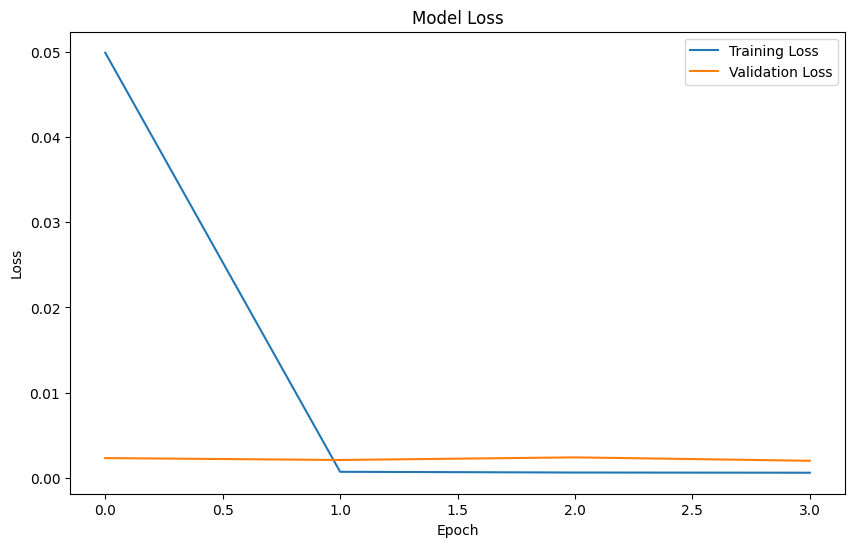

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### MAE Visualization

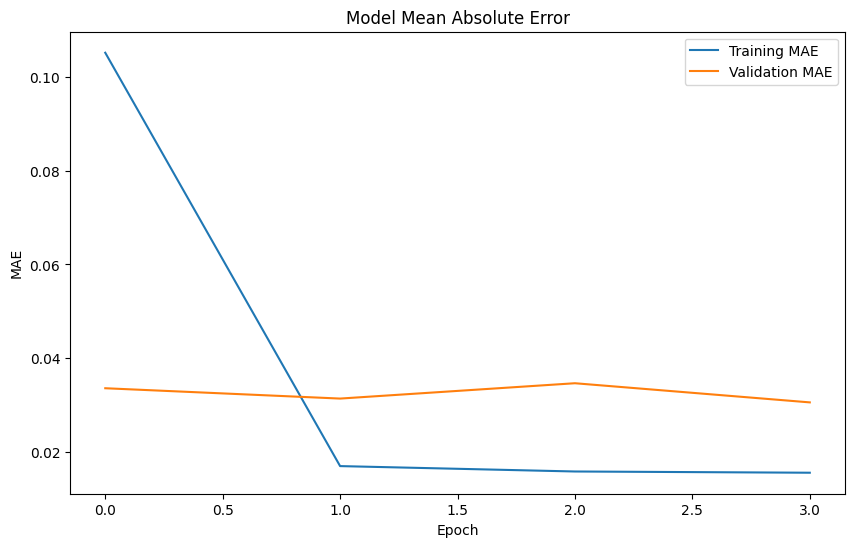

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions


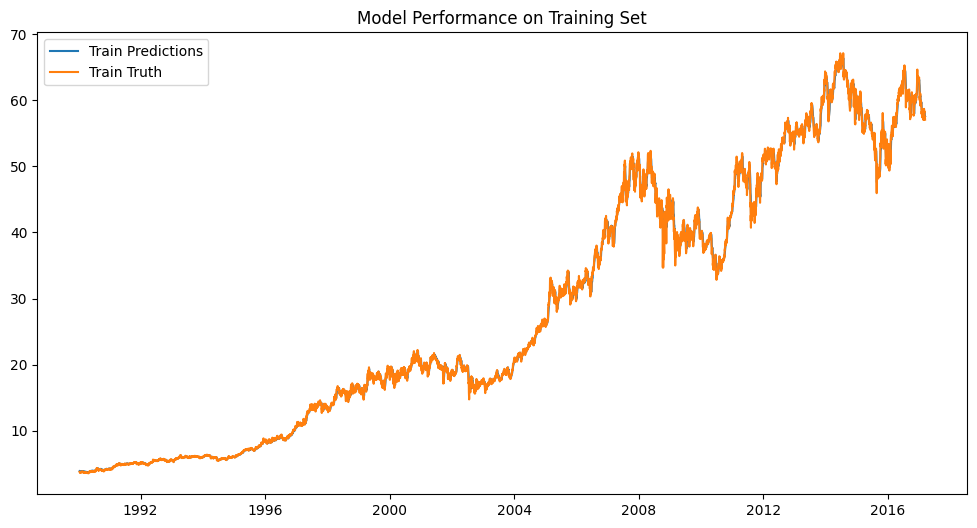

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_pred, label='Train Predictions')
plt.plot(dates_train, y_train_original, label='Train Truth')
plt.title('Model Performance on Training Set')
plt.legend()
plt.show()



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
Test Set MAE: 6.9403
Test Set MSE: 97.4288
Test Set RMSE: 9.8706


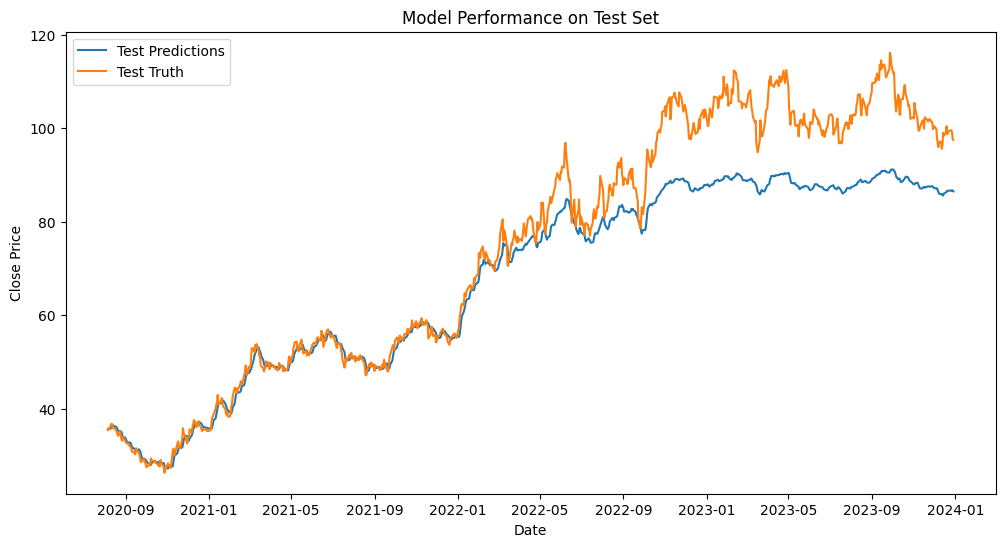

In [25]:
test_pred = model.predict(X_test).flatten()
test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_original, test_pred)
mse = mean_squared_error(y_test_original, test_pred)
rmse = np.sqrt(mse)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_pred, label='Test Predictions')
plt.plot(dates_test, y_test_original, label='Test Truth')
plt.title('Model Performance on Test Set')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()